In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gen = np.random.default_rng()

In [172]:
A = [1, 2, 3]
B = [3, 1, 2]
categories = ["chores", "finances", "activities"]


In [ ]:
def insist(x, priorities):
    return [0, 0, 0]


def compromise(x, priorities):
    return [1, 1, 1]


def random(x, priorities):
    return gen.integers(2, size=3)


def titfortat(x, priorities):
    if x[1] == []:
        return [1, 1, 1]
    return x[1][-1]


def grim(x, priorities):
    if x[1] == []:
        return [1, 1, 1]
    return np.minimum(x[1][-1], x[0][-1])


def gradual_forgiving(x, priorities, n=5):
    if x[1] == []:
        return [1, 1, 1]

    return np.min(x[1][-n:], axis=0)


def prioritised(x, priorities):
    mid = np.argwhere(priorities[0] == 2)[0, 0]
    return np.array([1, titfortat(x, priorities)[mid], 0])[priorities[0]-1]


def considerate(x, priorities):
    ret = np.zeros(3)
    for i in range(3):
        if priorities[0][i] > priorities[1][i]:
            ret[i] = 1
        elif priorities[0][i] == priorities[1][i]:
            ret[i] == titfortat(x, priorities)[i]
        else:
            ret[i] = 0


strategies = [insist, compromise, titfortat,
              grim, gradual_forgiving, random, prioritised]

In [235]:
def game(strategy_A, strategy_B, N, priorities=[A, B],):
    priorities = np.array(priorities)
    choices = [[], []]
    for _ in range(N):
        a = strategy_A(choices, priorities)
        b = strategy_B(choices[::-1], priorities[::-1])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

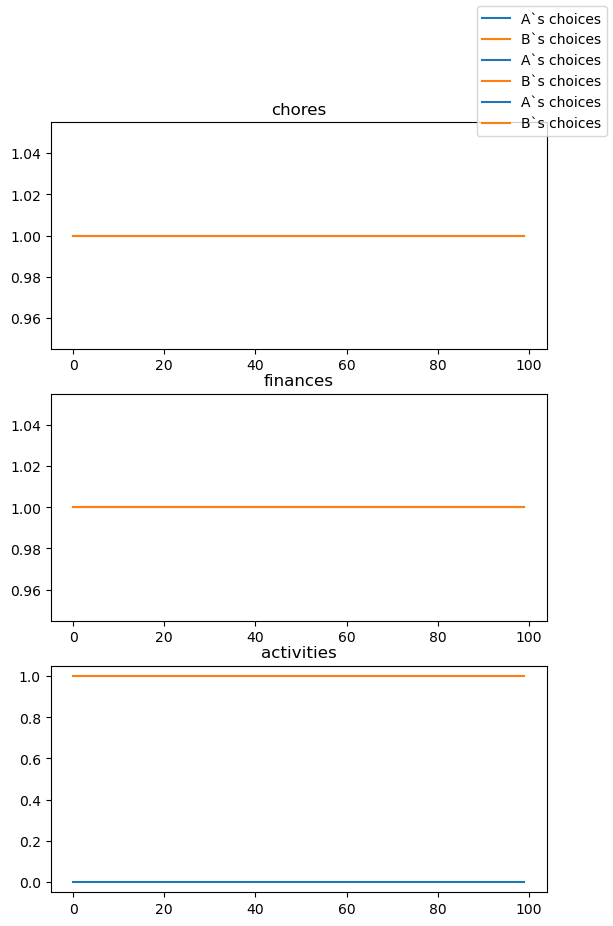

In [240]:
choices = game(prioritised, compromise, N=100)
fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i], label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()

In [237]:
subgame_payoffs = np.array([[
    [[0, 0],        [A[i], -B[i]]],
    [[-A[i], B[i]], [1.5, 1.5]]]
    for i in range(3)])


def mean_payoffs(strategy_A, strategy_B, N=10000):
    choices = game(strategy_A, strategy_B, N)
    ret = np.zeros(2)
    for i in range(3):  # subgame
        for j in range(len(choices[0])):  # iteration
            ret += subgame_payoffs[i, choices[i, j, 0], choices[i, j, 1]]
    return np.round(ret/N, 2)

In [241]:
N = 10000

payoffs = []
for i in range(len(strategies)):
    payoffs.append([])
    for j in range(len(strategies)):
        payoffs[-1].append(mean_payoffs(strategies[i], strategies[j], N = N))

In [242]:
labels = [x.__name__ for x in strategies]
df = pd.DataFrame(payoffs, index=labels, columns=labels)
df
# print(df.to_latex())

,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0, -0.0]","[0.0, -0.0]","[0.0, -0.0]","[3.03, -3.0]","[2.0, -1.0]"
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.83, 5.26]","[2.0, 6.0]"
titfortat,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.12, 1.12]","[3.0, 3.0]"
grim,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.99, -2.98]","[3.0, 3.0]"
gradual_forgiving,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.88, -2.75]","[3.0, 3.0]"
random,"[-2.98, 2.97]","[5.24, -0.74]","[1.14, 1.14]","[-2.99, 2.99]","[-2.73, 2.89]","[1.11, 1.12]","[1.62, 2.08]"
prioritised,"[-1.0, 3.0]","[6.0, 1.0]","[3.0, 3.0]","[3.0, 3.0]","[3.0, 3.0]","[2.13, 1.62]","[0.5, 4.5]"


In [9]:
def stochastic(x, p):
    if x[1] == [] or x[0] == []:
        return [1,1,1]
    p = np.array(p)
    prob = p[2 * np.array(x[0][-1]) + np.array(x[1][-1])]

    return [gen.choice(a=2, p = [1 - prob[i], prob[i]]) for i in range(3)]

In [10]:
p = [0,1,0,1] # p_dd, p_dc, p_cd, p_cc
stoch = lambda x:stochastic(x,p)
game(stoch,grim,N=1000)

array([[[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]]])

In [ ]:
def p_evolution(M, N, Q, replaced, rate):
    scores = np.zeros([Q, M])
    p = gen.uniform(size=[M, 4])
    # p[0] = [0,1,0,1]
    replaced = int(M * replaced)

    for k in range(Q):
        for i in range(M):
            def s1(x): return stochastic(x, p[i])
            for s2 in strategies:

                payoffA = mean_payoffs(s1, s2, N=N)
                payoffB = mean_payoffs(s2, s1, N=N)
                scores[k, i] += payoffA[0]
                scores[k, i] += payoffB[1]

            for j in range(1,replaced+1):
                if k == 0:
                    break

                def s2(x): return stochastic(x, p[inds[-j]])

                payoffA = mean_payoffs(s1, s2, N=N)
                payoffB = mean_payoffs(s2, s1, N=N)
                scores[k, i] += payoffA[0]
                scores[k, i] += payoffB[1]

        inds = np.argsort(scores[k])
        p[inds[:replaced]] = np.clip(
            p[inds[-replaced:]] + gen.normal(scale=rate, size = [replaced, 4]), 0, 1)
    scores /= 2 * (replaced + len(strategies))

    inds = np.argsort(scores[-1])
    scores = scores[:,inds]
    p = p[inds]
    return p, scores

In [142]:
M = 100  # number of strategies
N = 100  # number of rounds each game
Q = 30  # number of iterations
replaced = 0.1  # proportion of strategies replaced each generation
evolution_rate = 0.1  # rate of mutation

p, scores = p_evolution(M, N, Q, replaced, evolution_rate)

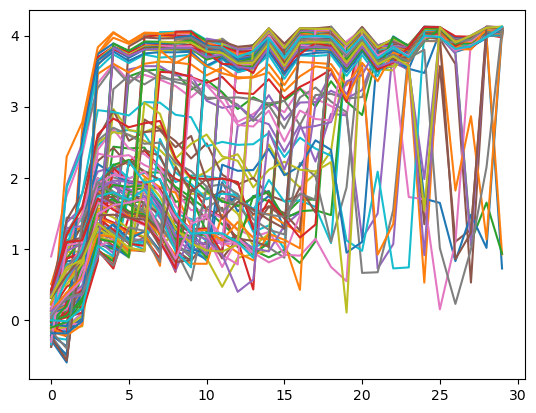

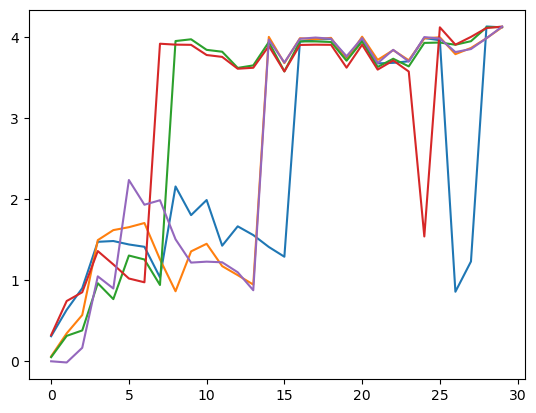

In [145]:
bestscores = scores[:,-replaced:]
plt.plot(scores)
plt.show()
plt.plot(scores[:,-5:])

In [155]:
print(scores[-1])
print(p)

[0.723125  0.923125  0.9303125 3.9746875 3.9953125 4.        4.0021875
 4.00375   4.0046875 4.0053125 4.010625  4.025     4.0278125 4.028125
 4.02875   4.029375  4.030625  4.030625  4.0309375 4.034375  4.0353125
 4.0359375 4.038125  4.0428125 4.044375  4.0453125 4.0459375 4.04625
 4.0471875 4.048125  4.04875   4.05      4.0515625 4.0521875 4.0525
 4.0528125 4.053125  4.0565625 4.0578125 4.0584375 4.05875   4.0625
 4.063125  4.0634375 4.064375  4.0646875 4.0646875 4.065     4.065
 4.065     4.065     4.06625   4.06625   4.0665625 4.066875  4.069375
 4.069375  4.070625  4.0728125 4.07375   4.075     4.0759375 4.0775
 4.0775    4.078125  4.0784375 4.08125   4.083125  4.08375   4.0859375
 4.0871875 4.08875   4.089375  4.0909375 4.0928125 4.0934375 4.09375
 4.0984375 4.099375  4.0996875 4.0996875 4.100625  4.1009375 4.101875
 4.101875  4.1025    4.108125  4.1084375 4.11      4.1125    4.1128125
 4.1140625 4.1146875 4.115625  4.1165625 4.116875  4.118125  4.1228125
 4.125     4.1253125]
[[0.